In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
def load_dataset(file):
    data = tf.keras.utils.image_dataset_from_directory(
    directory =file,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True)
    classes = data.class_names
    return classes, data

In [3]:
def ImgShow(dataset, samples_no, classes):
    plt.figure(figsize=(12, 12))
    for imageBatch, labelBatch in dataset.take(1):
        for i in range(samples_no):
            plt.subplot(int(samples_no/3)+1, 3, i+1)
            plt.title(classes[labelBatch[i].numpy()])
            plt.imshow(imageBatch[i].numpy().astype(int))
            plt.axis("off")

In [4]:
def splitDataset(data, train_size = 0.8, val_size = 0.1):
    size = len(data)
    train_batch = int(size*train_size)
    val_batch = int(size*val_size)
    test_batch = size - train_batch - val_batch
    train_ds = data.take(train_batch)
    val_ds = data.skip(train_batch).take(val_batch)
    test_ds = data.skip(train_batch).skip(val_batch).take(test_batch)
    train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [5]:
def createModel():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    model.add(tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE))
    model.add(tf.keras.layers.RandomFlip())
    model.add(tf.keras.layers.RandomRotation(0.2))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
    return model

In [6]:
def buildModel():
    input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL)
    model = createModel()
    model.build(input_shape=input_shape)
    model.summary()
    return model

In [7]:
def trainModel(model, train_ds, val_ds, epochs):
    model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics="accuracy")
    history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    validation_data=val_ds)
    return model, history

In [8]:
def prediction(model, file, imgShow=True):
    image = Image.open(file)
    image = np.array(image)
    image_batch = np.expand_dims(image, 0)
    prediction = model.predict(image_batch)
    index = np.argmax(prediction[0])
    confidence = np.max(prediction[0])*100
    if imgShow:
        plt.title(f"Prediction: {CLASSES[index]}\nConfidence: {confidence:.2f}")
        plt.imshow(image.astype(int))
        plt.axis("off")
    return confidence, CLASSES[index]

In [9]:
def saveModel(model):
    files = os.listdir("../models/")
    model_version=len(files)+1
    model.save(f"../models/{model_version}")

In [10]:
IMG_SIZE = 256
BATCH_SIZE=32
CHANNEL = 3
CLASSES, DATA = load_dataset("../PlantVillage")
N_CLASSES = len(CLASSES)

Found 20638 files belonging to 15 classes.


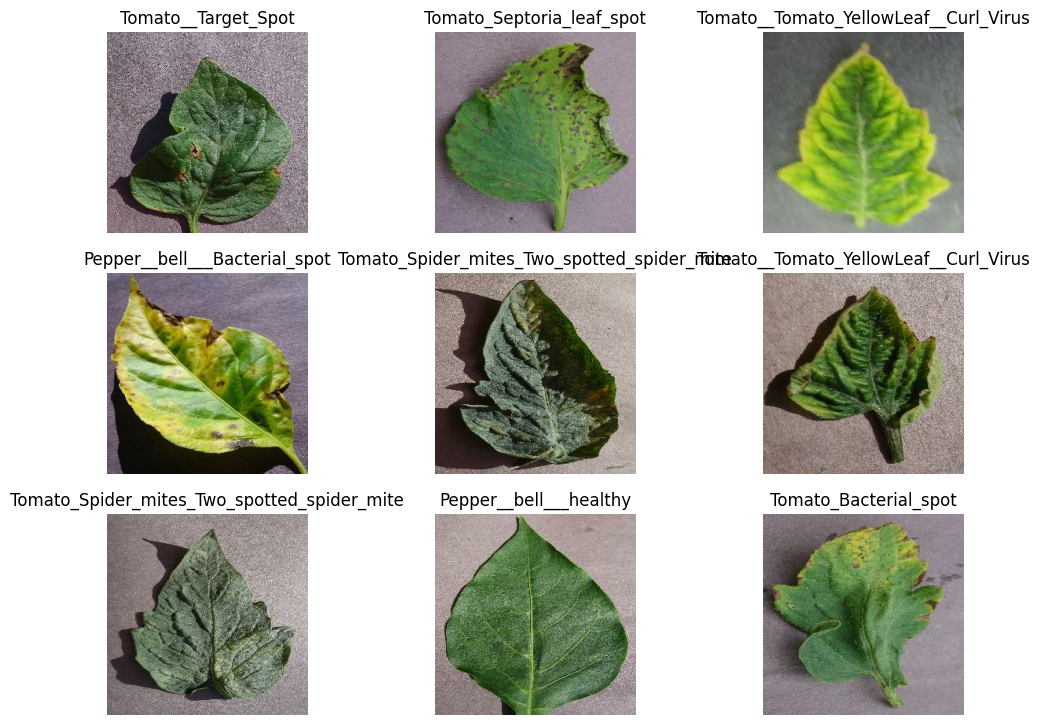

In [11]:
ImgShow(DATA, 9, CLASSES)

In [12]:
train_ds, val_ds, test_ds = splitDataset(DATA)
MODEL = buildModel()
MODEL, HISTORY=trainModel(MODEL, train_ds, val_ds, 20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 resizing (Resizing)         (32, 256, 256, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 256, 256, 3)         0         
                                                                 
 random_rotation (RandomRota  (32, 256, 256, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                      

In [13]:
MODEL.evaluate(test_ds)

65/65 [==============================] - 24s 248ms/step - loss: 0.3663 - accuracy: 0.8884


[0.3663226068019867, 0.8883541822433472]

1/1 [==============================] - 0s 231ms/step


(100.0, 'Tomato_Late_blight')

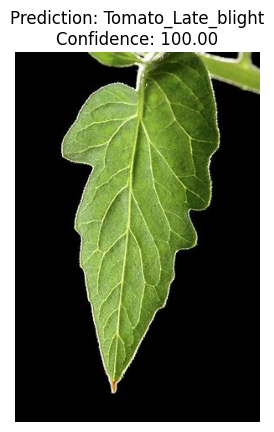

In [14]:
prediction(MODEL, "../prediction/1.jpeg")

1/1 [==============================] - 0s 132ms/step


(95.98884582519531, 'Tomato_Septoria_leaf_spot')

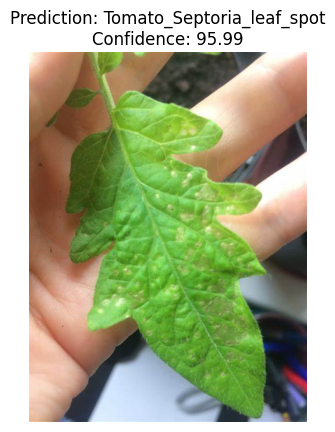

In [15]:
prediction(MODEL, "../prediction/2.jpeg")

Text(0.5, 1.0, 'Model Training History')

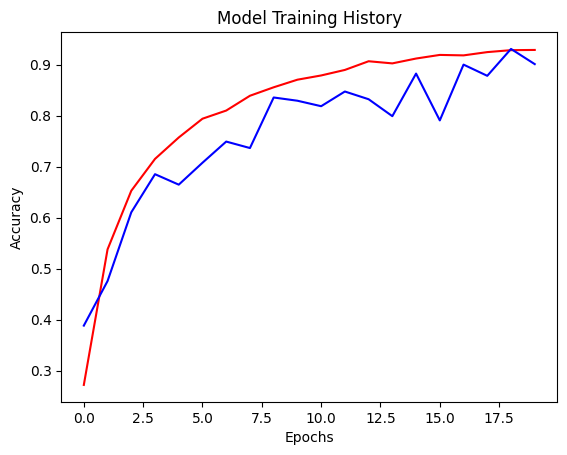

In [17]:
plt.plot(HISTORY.history['accuracy'], c='red')
plt.plot(HISTORY.history['val_accuracy'], c='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training History")

Text(0.5, 1.0, 'Model Training History')

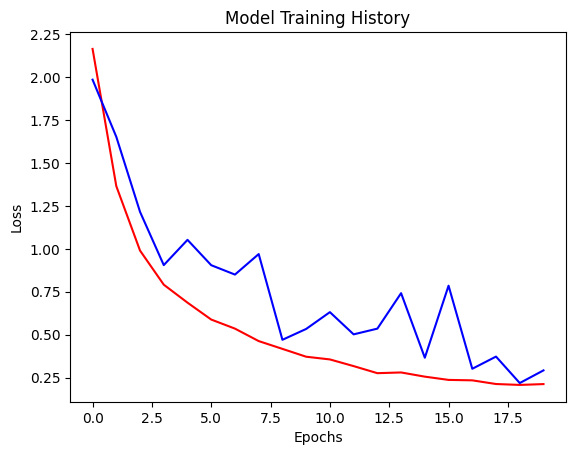

In [18]:
plt.plot(HISTORY.history['loss'], c='red')
plt.plot(HISTORY.history['val_loss'], c='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training History")

In [16]:
saveModel(MODEL)

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
